In [1]:
import time
import gc
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys
import os
sys.path.append(os.getcwd())
from visualizer.main import Visualizer as vis
# Importujemy bezpośrednio z pliku quadtree.py
from algorithms.quadtree.quadtree import QuadTree, Rectangle, Point, build_quadtree
from algorithms.quadtree.quadtree_visualization import quadtree_vis
from algorithms.quadtree.quadtree_query_visualization import visualize_quadtree_query

from algorithms.utils.build_tree import build_tree, get_points_in_area
from algorithms.utils.visualize_search_result import visualize_search_result

from points_generators import *

from algorithms.kd_tree.kd_class import *
from algorithms.kd_tree.kd_build_visualization import *
from algorithms.kd_tree.kd_query_visualization import * 


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import random

In [2]:
def points_visualization(points):
    vis = Visualizer()
    for pkt in points:
        vis.add_point(pkt, color = 'blue')
    return vis

## Wprowadzenie

Notatnik ten ma służyć jako narzędzie pozwalające na porównanie działania strktur KDTree oraz quadtree w zapytaniach, polegających na szukaniu punktów zawartych w obrębie prostokata

# Testowanie algorytmów

# Wizualizacja budowy oraz działania algorytmów #

Poniżej pokżemy wizualizacje przedstawiającą budowę oraz wizualizację zapytania dla 100 punktów wylosowanych jednostajnie z przedziału [0, 800] x [0, 800]

In [3]:
points = [(random.uniform(0, 800), random.uniform(0, 800)) for _ in range(50)]

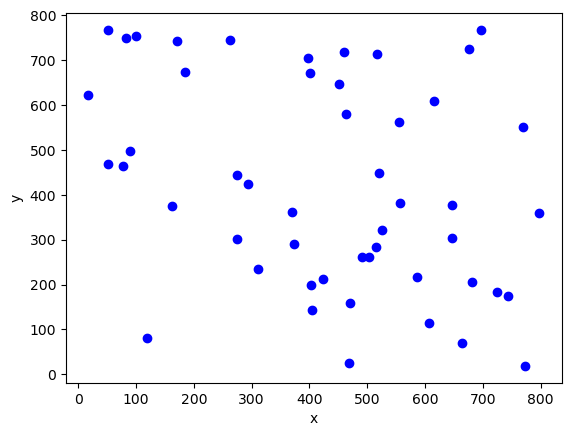

In [4]:
points_visualization(points).show()

## quadtree ##

budowa quadtree wizualizacja

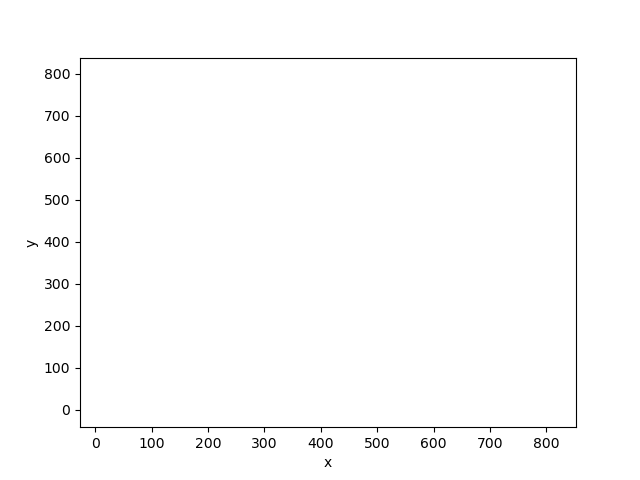

In [5]:

k = 4
vis= quadtree_vis(points, k)
vis.show_gif(interval=200)

działanie zapytania quadtree

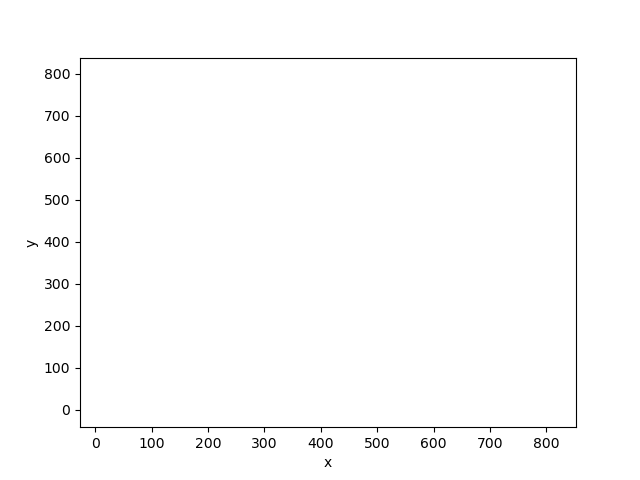

In [6]:

search_area = Rectangle(400, 350, 200, 150)
vis_query = visualize_quadtree_query(points, search_area, 4)
vis_query.show_gif(interval=200) 

## kd-tree ##

wizualizacja budowy kd-tree

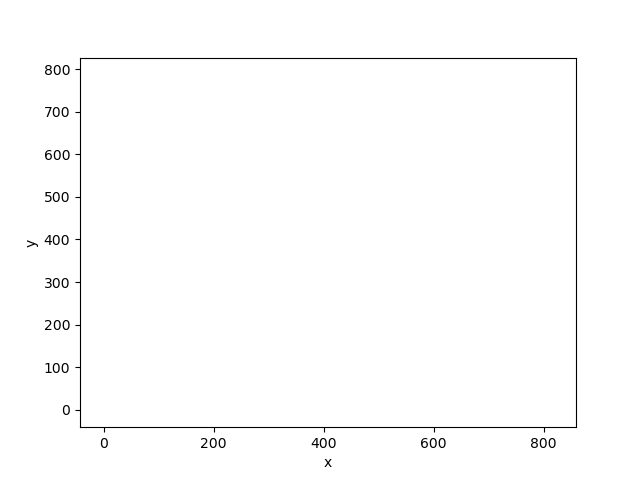

In [7]:
vis_kd = kd_build_visualization(points)
vis_kd.show_gif(interval=500)



działanie kd-tree wizualizacja

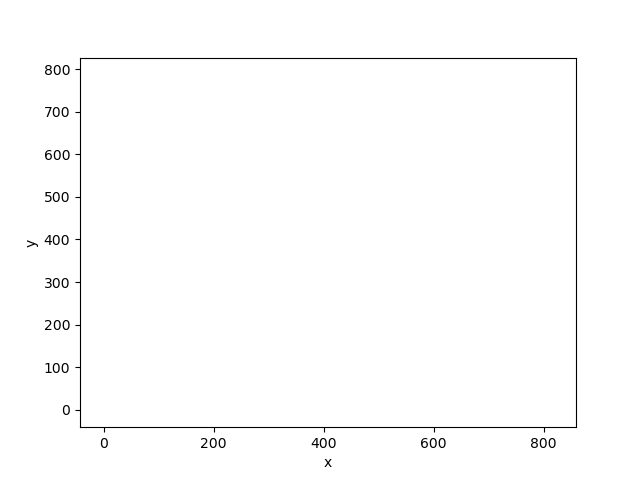

In [8]:
tree = KDTree(points)
query_box = (200, 600, 200, 500) # x_min, x_max, y_min, y_max
vis_kd2 = visualize_kdtree_animation(tree, points, query_box)
vis_kd2.show_gif(interval=500)

Działanie algorytmów na zadanej przez użytkonika liście punktów (jako przykład losowo wygenerowane punkty z rozkładu jednostajnego)

Znaleziono 20 punktów w obszarze wyszukiwania.
 Punkty: [(16.8, 5.2), (18.2, 15.7), (7.1, 19.0), (14.9, 19.8), (18.2, 4.0), (21.4, 7.2), (25.9, 12.0), (0.3, 30.5), (5.3, 24.9), (5.9, 37.9), (16.7, 27.7), (24.9, 27.6), (23.4, 35.6), (29.5, 0.4), (33.9, 4.1), (34.4, 8.5), (31.1, 9.2), (34.2, 11.8), (26.7, 29.7), (38.5, 20.1)] 


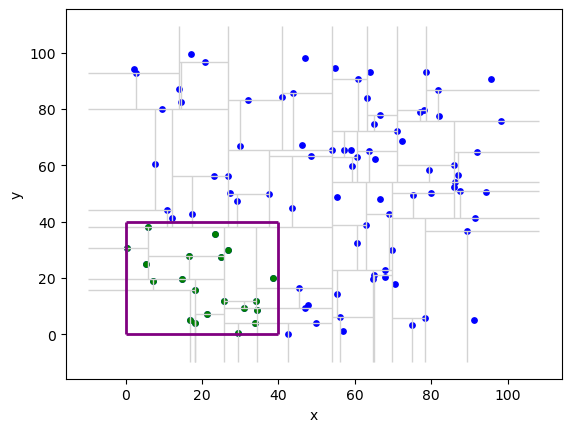

In [21]:
N = 100 # liczba punktów 
ALGO = 'kdtree' # wybór algorytmu, który chcemy użyć 'quadtree' lub 'kdtree'

# wybór punktów
points = generate_uniform_points(0, 100, N)

# wybór obszaru zapytania ( x_srodek , y_srodek , połowa szerokości , połowa wysokości )
search_area = Rectangle (20 , 20 , 20 , 20)

# wykonanie wyszukiwania
found = get_points_in_area ( ALGO , points , search_area )
print ( f'Znaleziono { len ( found ) } punktów w obszarze wyszukiwania.' )
print ( f' Punkty: { found } ' )

# pokazanie wyniku wyszukiwania
vis = visualize_search_result ( points , search_area , found_points = found ,
algorithm = ALGO )
vis.show()

## Wizualizacja wyników algorytmów na przykładowych zbiorach danych

Poniżej przedstawimy wizualizacje zapytań na przykładzie zbiorów testowych, dla których będziemy potem porównywać czasy działania algorytmów

# Punkty losowane zgodnie z rozkładem jednostajnym

UNIFORM
Search rect: (200, 600, 250, 550)
Found QT: 83  sample: [(np.float64(227.2999785813231), np.float64(277.21523408312896)), (np.float64(238.20997274058496), np.float64(287.78922652842283)), (np.float64(267.4145602117119), np.float64(261.5994807157361)), (np.float64(370.110133725328), np.float64(285.4525077560998)), (np.float64(380.28135560890377), np.float64(286.20016068704433)), (np.float64(399.5092094613762), np.float64(253.41552383183793)), (np.float64(242.00424684427756), np.float64(314.36452811141334)), (np.float64(205.5819956700444), np.float64(301.464510928636)), (np.float64(284.5953116257675), np.float64(315.05790008636046)), (np.float64(248.31889340743984), np.float64(371.7071283229517)), (np.float64(223.25303402270436), np.float64(354.6329431670065)), (np.float64(225.59429473632076), np.float64(396.0542529350497)), (np.float64(205.00382669923926), np.float64(387.53207223324574)), (np.float64(324.9137551458729), np.float64(318.10925355206007)), (np.float64(370.2995884256

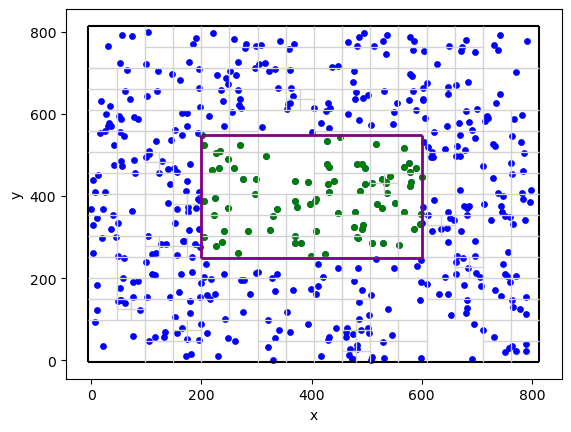

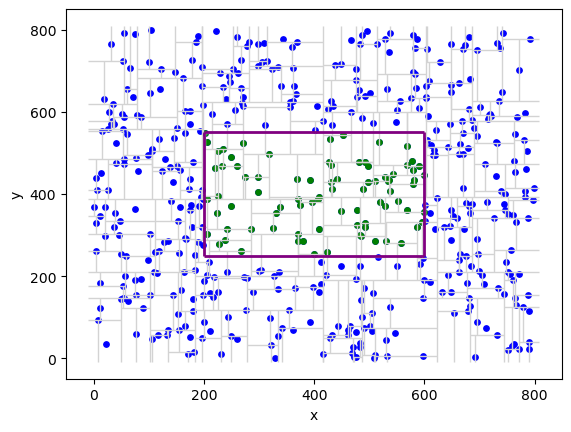

In [18]:
points = generate_uniform_points(0, 800, 500)
vis = points_visualization(points)
#vis.save("images/uniform_set.png")
search_area = Rectangle(400, 400, 200, 150) # x_środek, y_środek, połowa szerokości, połowa wysokości

print("UNIFORM")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
#vis_qt.save("images/uniform_result_qt.png")
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
#vis_kd.save("images/uniform_result.png")




# Działanie na punktach wylosowanych zgodnie z rozkładem normalnym 


NORMAL / GAUSS
Search rect: (320, 480, 320, 480)
Found QT: 237  sample: [(np.float64(337.4478888094483), np.float64(321.96650288768416)), (np.float64(338.44360333276586), np.float64(321.4859960291116)), (np.float64(332.41273115005185), np.float64(326.62379662771525)), (np.float64(344.5899665903895), np.float64(332.1465021430354)), (np.float64(327.41610861699047), np.float64(347.7590051829554)), (np.float64(339.78679871593647), np.float64(346.99924050157045)), (np.float64(342.5371442810106), np.float64(346.30528097305864)), (np.float64(340.79536131842195), np.float64(341.91169110439193)), (np.float64(394.09799321507825), np.float64(320.90985214083537)), (np.float64(398.5949228448772), np.float64(322.19895893825503)), (np.float64(362.4586412660524), np.float64(333.6470943582585)), (np.float64(365.9242303527023), np.float64(335.98308284269456)), (np.float64(360.04262679742874), np.float64(348.4844985613859)), (np.float64(363.9025445877872), np.float64(345.7511783275687)), (np.float64(366.

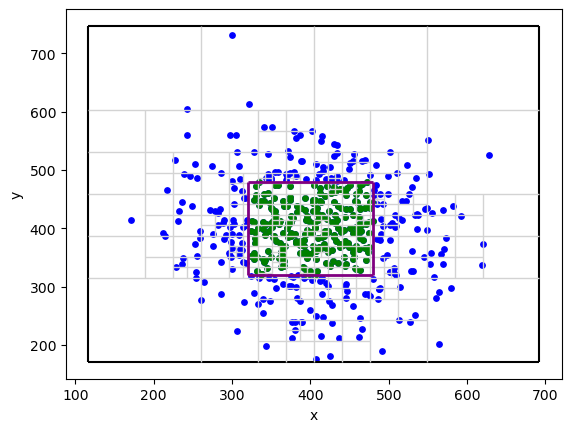

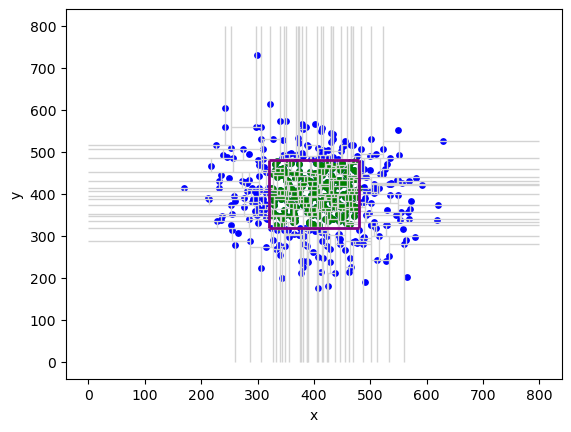

In [13]:
points = generate_normal_points(mean=400, std=80, n=500)
vis = points_visualization(points)
vis.save("images/normal_set.png")
search_area = Rectangle(400, 400, 80, 80)

print("NORMAL / GAUSS")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_qt.save("images/normal_result_qt.png")
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/normal_result.png")


# Punkty skupione w 4 zbiorowiska (klastry)

CLUSTERS
Search rect: (120, 280, 520, 680)
Found QT: 121  sample: [(np.float64(166.26497589324168), np.float64(524.2250381693927)), (np.float64(187.99115777757495), np.float64(539.6906607314532)), (np.float64(184.59249060072142), np.float64(530.9158140747306)), (np.float64(141.11791934045152), np.float64(580.8858583814915)), (np.float64(139.60231632775836), np.float64(587.7203994023113)), (np.float64(169.63151787395526), np.float64(569.1909817061348)), (np.float64(161.25279464179732), np.float64(567.0579555734419)), (np.float64(152.79069063372452), np.float64(555.6213203383386)), (np.float64(171.30204859568752), np.float64(551.5738930825546)), (np.float64(185.11290080034055), np.float64(559.328313601455)), (np.float64(192.45423225546014), np.float64(561.2725038617382)), (np.float64(180.70302387893355), np.float64(566.3544246453785)), (np.float64(178.59259057907624), np.float64(569.7744016224451)), (np.float64(199.1067545799072), np.float64(567.4264745799178)), (np.float64(168.395097939

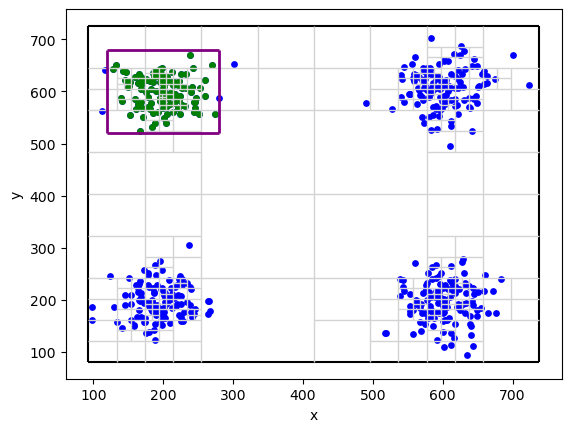

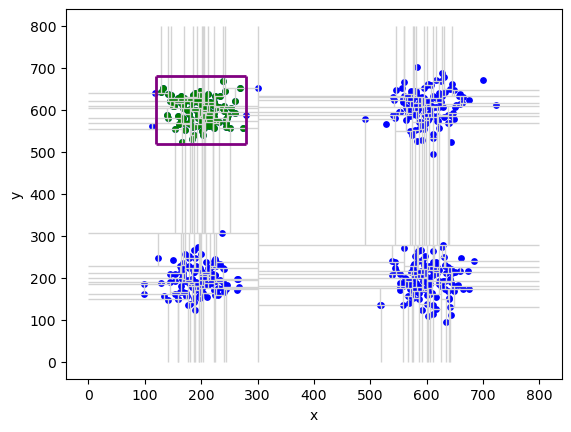

In [19]:
points = generate_clustered_points(
    cluster_centers=[(200, 200), (200, 600), (600, 200), (600, 600)],
    cluster_std=35,
    points_per_cluster=125
)
vis = points_visualization(points)
vis.save("images/clustered_set.png")
search_area = Rectangle(200, 600, 80, 80)  # celuję w klaster (200,600)

print("CLUSTERS")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_qt.save("images/clustered_result_qt.png")
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/clustered_result.png")


# Punkty skupione na przekatnej

COLLINEAR / DIAGONAL
Search rect: (300, 500, 300, 500)
Found QT: 64  sample: [(np.float64(306.124513899549), np.float64(306.124513899549)), (np.float64(301.04308133967146), np.float64(301.04308133967146)), (np.float64(304.30258353047856), np.float64(304.30258353047856)), (np.float64(308.72591562636933), np.float64(308.72591562636933)), (np.float64(309.36583603176405), np.float64(309.36583603176405)), (np.float64(306.75718450987546), np.float64(306.75718450987546)), (np.float64(310.8259862486768), np.float64(310.8259862486768)), (np.float64(310.16113883595295), np.float64(310.16113883595295)), (np.float64(321.33900624340515), np.float64(321.33900624340515)), (np.float64(312.5374146154444), np.float64(312.5374146154444)), (np.float64(329.30614410608376), np.float64(329.30614410608376)), (np.float64(326.1508079226063), np.float64(326.1508079226063)), (np.float64(333.11599692158165), np.float64(333.11599692158165)), (np.float64(334.8443036940331), np.float64(334.8443036940331)), (np.float6

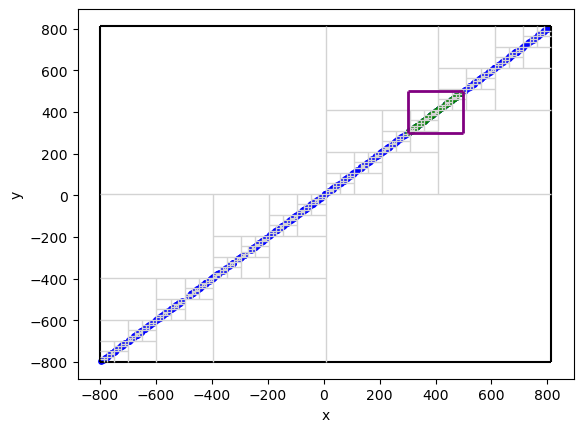

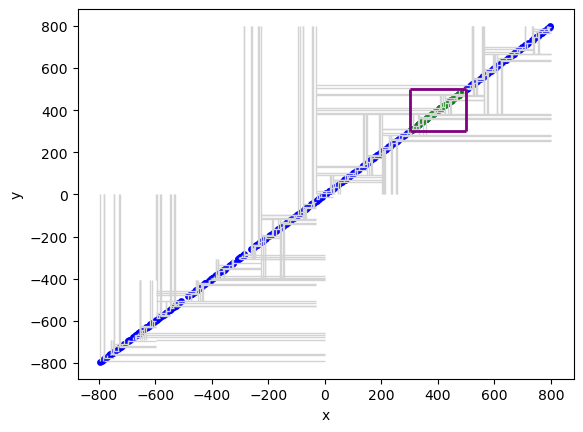

In [18]:
points = generate_collinear_points(a=(0,0), b=(800,800), n=500, x_range=800)  
vis = points_visualization(points)
vis.save("images/collinear_set.png")
search_area = Rectangle(400, 400, 100, 100)  # mały kwadrat przecinający prostą

print("COLLINEAR / DIAGONAL")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_qt.save("images/collinear_result_qt.png")
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/collinear_result.png")


# Kwadrat z przekątnymi

SQUARE + DIAGONALS
Search rect: (280, 520, 280, 520)
Found QT: 59  sample: [(np.float64(295.6922387600277), np.float64(295.6922387600277)), (np.float64(292.04017868707047), np.float64(292.04017868707047)), (np.float64(303.77087792329814), np.float64(303.77087792329814)), (np.float64(313.20970355754713), np.float64(313.20970355754713)), (np.float64(317.4626036797523), np.float64(317.4626036797523)), (np.float64(324.7040895456717), np.float64(324.7040895456717)), (np.float64(323.62498248855786), np.float64(323.62498248855786)), (np.float64(319.7424781935936), np.float64(319.7424781935936)), (np.float64(327.5929532502117), np.float64(327.5929532502117)), (np.float64(330.8427653463124), np.float64(330.8427653463124)), (np.float64(342.9350278196056), np.float64(342.9350278196056)), (np.float64(333.16048965114237), np.float64(333.16048965114237)), (np.float64(354.75629143725865), np.float64(354.75629143725865)), (np.float64(388.9003438667651), np.float64(388.9003438667651)), (np.float64(502.

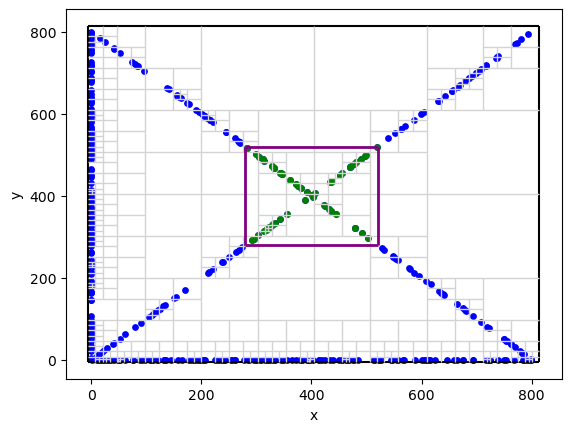

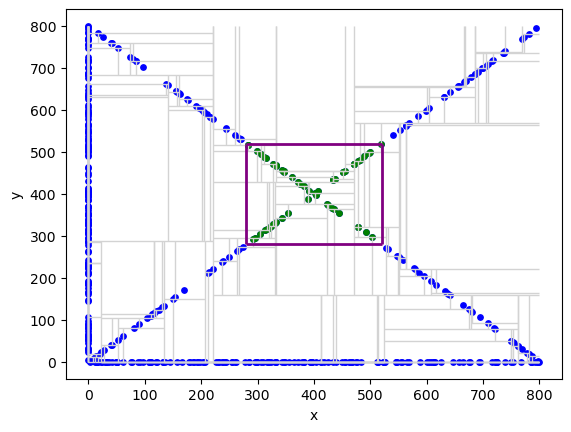

In [17]:
points = generate_square_points(
    a=(0, 0), b=(800, 0), c=(800, 800), d=(0, 800),
    axis_n=150, diag_n=100
)
vis = points_visualization(points)
vis.save("images/square_set.png")
search_area = Rectangle(400, 400, 120, 120)  # okolice przecięcia przekątnych

print("SQUARE + DIAGONALS")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_qt.save("images/square_result_qt.png")
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/square_result.png")



# Siatka

GRID
Search rect: (80, 320, 80, 320)
Found QT: 36  sample: [(114.28571428571428, 114.28571428571428), (152.38095238095238, 114.28571428571428), (190.47619047619048, 114.28571428571428), (114.28571428571428, 190.47619047619048), (114.28571428571428, 152.38095238095238), (152.38095238095238, 152.38095238095238), (152.38095238095238, 190.47619047619048), (190.47619047619048, 152.38095238095238), (190.47619047619048, 190.47619047619048), (228.57142857142856, 114.28571428571428), (266.6666666666667, 114.28571428571428), (228.57142857142856, 190.47619047619048), (228.57142857142856, 152.38095238095238), (266.6666666666667, 152.38095238095238), (266.6666666666667, 190.47619047619048), (304.76190476190476, 114.28571428571428), (304.76190476190476, 190.47619047619048), (304.76190476190476, 152.38095238095238), (114.28571428571428, 228.57142857142856), (190.47619047619048, 228.57142857142856)]
Found KD: 36  sample: [(114.28571428571428, 114.28571428571428), (152.38095238095238, 114.2857142857142

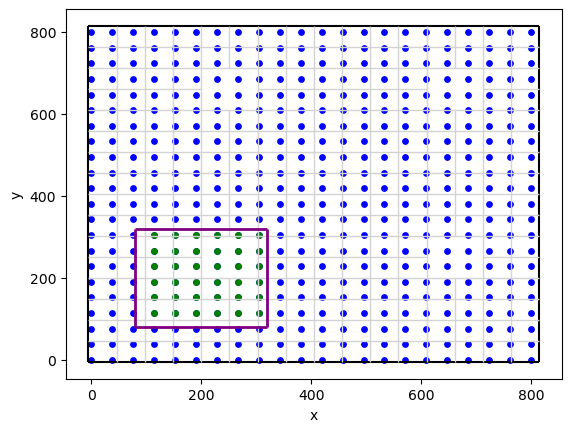

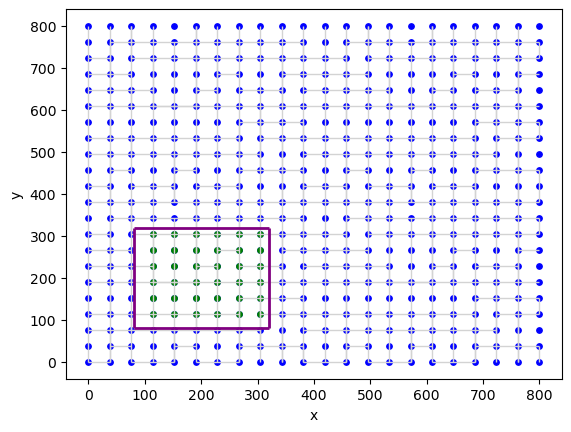

In [16]:
points = generate_grid_points(n=22)
scale = 800 / 21
points = [(i*scale, j*scale) for (i, j) in points]
vis= points_visualization(points)
vis.save("images/grid_set.png")
search_area = Rectangle(200, 200, 120, 120)

print("GRID")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_qt.save("images/grid_result_qt.png")
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/grid_result.png")


# Spirala

SPIRAL
Search rect: (470, 630, 280, 520)
Found QT: 59  sample: [(np.float64(515.0908799576724), np.float64(285.99089984722923)), (np.float64(520.647586881727), np.float64(291.9629615889449)), (np.float64(530.1776790986041), np.float64(294.74241686996754)), (np.float64(471.6965349467421), np.float64(361.65926590541534)), (np.float64(474.0651653206663), np.float64(369.52586743501604)), (np.float64(484.66347497194016), np.float64(360.0692079281976)), (np.float64(475.3554592163281), np.float64(354.68240336936265)), (np.float64(481.06336642614826), np.float64(371.3274561180709)), (np.float64(470.71851005150324), np.float64(382.7509894473894)), (np.float64(485.7664820763779), np.float64(383.60558917076173)), (np.float64(479.01967703788097), np.float64(376.4534429642456)), (np.float64(481.060873613874), np.float64(392.8366637624022)), (np.float64(482.54562939679096), np.float64(388.49316754144144)), (np.float64(490.2668863743368), np.float64(396.58857618303557)), (np.float64(547.09766010681),

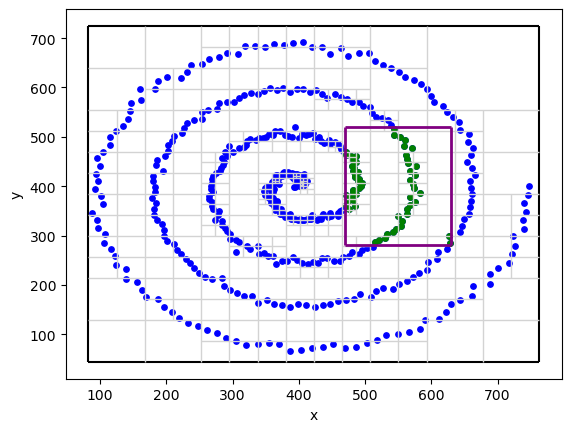

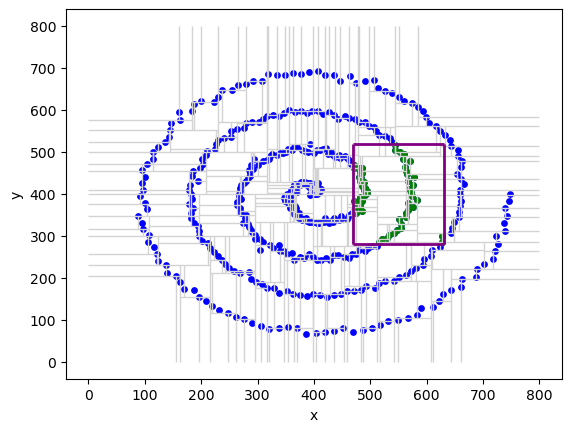

In [15]:
points = generate_spiral_points(n=500, center=(400, 400), max_radius=350, turns=4)
vi= points_visualization(points)
vi.save("images/spiral_set.png")
search_area = Rectangle(550, 400, 80, 120)  # pasek po prawej od środka

print("SPIRAL")

# QuadTree
qt = QuadTree(Rectangle(400, 400, 400, 400), capacity=4)
for x, y in points:
    qt.insert(Point(x, y))

found_qt = []
qt.query(search_area, found_qt)

# KDTree
kd = KDTree(points)
q_rect = (search_area.x - search_area.w, search_area.x + search_area.w,
          search_area.y - search_area.h, search_area.y + search_area.h)
found_kd = kd.query(q_rect)

qt_as_xy = {(p.x, p.y) for p in found_qt}
kd_as_xy = set(found_kd)

print("Search rect:", q_rect)
print("Found QT:", len(found_qt), " sample:", [(p.x, p.y) for p in found_qt[:20]])
print("Found KD:", len(found_kd), " sample:", found_kd[:20])
print("Sets equal:", qt_as_xy == kd_as_xy)

vis_qt = visualize_search_result(points, search_area, found_qt, algorithm="quadtree")
vis_qt.show()
vis_qt.save("images/spiral_result_qt.png")
vis_kd = visualize_search_result(points, search_area, found_kd, algorithm="kdtree")
vis_kd.show()
vis_kd.save("images/spiral_result.png")


## Porównanie działania algorytmów ##

Chcemy teraz porównać działanie obydwu algorytmów na wybranych zbiorach testowych

In [ ]:
import time
import gc
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




N_VALUES = [1000, 5000, 10000, 25000, 50000, 100000, 200000]
REPEATS = 10  

def get_uniform(n): 
    return generate_uniform_points(0, 1000, n)

def get_normal(n): 
    return generate_normal_points(500, 50, n)

def get_clusters(n):
    centers = [(200, 200), (200, 800), (800, 200), (800, 800)]
    return generate_clustered_points(centers, 30, n // 4)

def get_diagonal(n):
    return generate_collinear_points((0,0), (1000,1000), n, x_range=1000)

def get_grid(n):
    side = int(np.sqrt(n))
    pts = generate_grid_points(side)
    scale = 1000 / max(side, 1)
    return [(p[0]*scale, p[1]*scale) for p in pts]

def get_spiral(n): 
    return generate_spiral_points(n, (500,500), 450, 5)

def get_square(n):
    # Dzielimy N na 4 części (2 osie, 2 przekątne)
    part = n // 4
    return generate_square_points((0,0), (1000,0), (1000,1000), (0,1000), part, part)

# Definicja scenariuszy testowych 
TEST_CASES = [
    {"name": "Uniform", "gen": get_uniform, "query": (400, 600, 400, 600)},
    {"name": "Normal (Gauss)", "gen": get_normal, "query": (480, 520, 480, 520)}, # Gęste centrum
    {"name": "Clusters", "gen": get_clusters, "query": (180, 220, 180, 220)},     # Jeden klaster
    {"name": "Diagonal", "gen": get_diagonal, "query": (450, 550, 450, 550)},     # Przecięcie linii
    {"name": "Grid", "gen": get_grid, "query": (100, 300, 100, 300)},             # Wycinek siatki
    {"name": "Spiral", "gen": get_spiral, "query": (550, 750, 450, 650)},         # Przecięcie przekatnych
    {"name": "Square + Diags", "gen": get_square, "query": (400, 600, 400, 600)}  # Centrum
]


os.makedirs('data_test', exist_ok=True)
os.makedirs('plots_test', exist_ok=True)

for config in TEST_CASES:
    name = config["name"]
    gen_func = config["gen"]
    q_rect = config["query"] 
    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("+", "plus")
    
    print(f"\ Zbiór: {name}")
    print(f"{'N':<8} | {'KD Build':<10} | {'QT Build':<10} | {'KD Query':<10} | {'QT Query':<10} | {'Found':<6}")
    print("-" * 75)

    
    try:
        master_data = gen_func(max(N_VALUES))
        random.shuffle(master_data) 
    except Exception as e:
        print(f"Błąd generatora: {e}")
        continue
        
    
    q_xmin, q_xmax, q_ymin, q_ymax = q_rect
    qw, qh = (q_xmax - q_xmin) / 2, (q_ymax - q_ymin) / 2
    qcx, qcy = q_xmin + qw, q_ymin + qh
    qt_query_obj = Rectangle(qcx, qcy, qw, qh)
    
    stats = []

    for n in N_VALUES:
       
        pts = master_data[:n]
        
        t_kd_build_sum = 0; t_qt_build_sum = 0
        t_kd_query_sum = 0; t_qt_query_sum = 0
        last_found = 0

        
        for _ in range(REPEATS):
            
           
            gc.disable()
            t0 = time.perf_counter()
            kd = KDTree(pts)
            t_kd_build_sum += (time.perf_counter() - t0)
            gc.enable()
            
       
            gc.disable()
            t0 = time.perf_counter()
            
            qt = build_quadtree(pts, capacity=10)
            t_qt_build_sum += (time.perf_counter() - t0)
            gc.enable()
            
           
            q_loops = 5
            t0 = time.perf_counter()
            for _ in range(q_loops):
                res = kd.query(q_rect)
            t_kd_query_sum += (time.perf_counter() - t0) / q_loops
            last_found = len(res)
            
            
            t0 = time.perf_counter()
            for _ in range(q_loops):
                res_qt = []
                qt.query(qt_query_obj, res_qt)
            t_qt_query_sum += (time.perf_counter() - t0) / q_loops

        
        avg_build_kd = t_kd_build_sum / REPEATS
        avg_build_qt = t_qt_build_sum / REPEATS
        avg_query_kd = t_kd_query_sum / REPEATS
        avg_query_qt = t_qt_query_sum / REPEATS
        
        print(f"{n:<8} | {avg_build_kd:.5f}s  | {avg_build_qt:.5f}s  | {avg_query_kd:.5f}s  | {avg_query_qt:.5f}s  | {last_found}")
        
        stats.append({
            "N": n, "Build_KD": avg_build_kd, "Build_QT": avg_build_qt,
            "Query_KD": avg_query_kd, "Query_QT": avg_query_qt, "Found": last_found
        })

    df = pd.DataFrame(stats)
    df.to_csv(f"data/{safe_name}.csv", index=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Wyniki: {name}", fontsize=14)
    
    ax1.plot(df["N"], df["Build_KD"], 'o-', label="KD-Tree")
    ax1.plot(df["N"], df["Build_QT"], 's--', label="QuadTree")
    ax1.set_title("Czas Budowy"); ax1.set_xlabel("N"); ax1.set_ylabel("s")
    ax1.legend(); ax1.grid(alpha=0.3)
    
    ax2.plot(df["N"], df["Query_KD"], 'o-', label="KD-Tree")
    ax2.plot(df["N"], df["Query_QT"], 's--', label="QuadTree")
    ax2.set_title(f"Czas Zapytania"); ax2.set_xlabel("N")
    ax2.legend(); ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"plots/{safe_name}.png")
    plt.close()


🚀 ROZPOCZYNAM BENCHMARK (Incremental Method, Max N=200000)...

📊 Zbiór: Uniform
N        | KD Build   | QT Build   | KD Query   | QT Query   | Found 
---------------------------------------------------------------------------
1000     | 0.00973s  | 0.01603s  | 0.00011s  | 0.00015s  | 40
5000     | 0.01858s  | 0.02167s  | 0.00016s  | 0.00033s  | 203
10000    | 0.05276s  | 0.06439s  | 0.00047s  | 0.00056s  | 405
25000    | 0.14911s  | 0.15925s  | 0.00162s  | 0.00063s  | 999
50000    | 0.38868s  | 0.47308s  | 0.00385s  | 0.00206s  | 1984
100000   | 0.94858s  | 1.07667s  | 0.00587s  | 0.00426s  | 4031
200000   | 2.53326s  | 2.88680s  | 0.01606s  | 0.01372s  | 8007

📊 Zbiór: Normal (Gauss)
N        | KD Build   | QT Build   | KD Query   | QT Query   | Found 
---------------------------------------------------------------------------
1000     | 0.01413s  | 0.01784s  | 0.00012s  | 0.00010s  | 114
5000     | 0.01911s  | 0.02331s  | 0.00043s  | 0.00032s  | 529
10000    | 0.05272s  | 0.06578s  |

In [9]:
# testy 2
import os
import time
import random
import numpy as np
import pandas as pd
import glob

# Twoje importy:
# from algorithms.kd_tree.kd_class import KDTree
# from algorithms.quadtree.quadtree import build_quadtree, Rectangle

# from generators import (
#     generate_uniform_points,
#     generate_normal_points,
#     generate_grid_points,
#     generate_clustered_points,
#     generate_collinear_points,
#     generate_spiral_points,
#     generate_square_points,
# )

SEED = 2137
REPEATS = 3
QT_CAPACITY = 10
N_VALUES = [1000, 5000, 10000, 25000, 50000]

os.makedirs("data", exist_ok=True)

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)

def rect_to_qt(xmin, xmax, ymin, ymax):
    cx = (xmin + xmax) / 2
    cy = (ymin + ymax) / 2
    hw = (xmax - xmin) / 2
    hh = (ymax - ymin) / 2
    return Rectangle(cx, cy, hw, hh)

def qt_set(found_qt):
    return {(p.x, p.y) for p in found_qt}

def kd_set(found_kd):
    return set(found_kd)

# ----------------------------
# TESTY (generator + query)
# ----------------------------
TESTS = [
    {
        "name": "Uniform",
        "gen": lambda n: generate_uniform_points(0, 1000, n),
        "query": (400, 600, 400, 600),
        "desc": "Równomierny rozkład (typowy przypadek)."
    },
    {
        "name": "Normal",
        "gen": lambda n: generate_normal_points(500, 80, n),
        "query": (450, 550, 450, 550),
        "desc": "Gauss w centrum (gęsty środek, rzadkie obrzeża)."
    },
    {
        "name": "Clusters",
        "gen": lambda n: generate_clustered_points(
            [(250,250), (750,250), (250,750), (750,750)], 60, max(1, n//4)
        )[:n],
        "query": (190, 310, 190, 310),
        "desc": "4 klastry (wyspy gęstości)."
    },
    {
        "name": "Grid",
        "gen": lambda n: [(x*(1000/max(int(np.sqrt(n))-1,1)), y*(1000/max(int(np.sqrt(n))-1,1)))
                          for (x,y) in generate_grid_points(int(np.sqrt(n)))],
        "query": (200, 400, 200, 400),
        "desc": "Siatka (regularne dane, bez losowości)."
    },
    {
        "name": "Collinear",
        "gen": lambda n: generate_collinear_points((0,0), (1000,1000), n, x_range=1000),
        "query": (450, 550, 450, 550),
        "desc": "Punkty współliniowe (degeneracja ~1D)."
    },
    {
        "name": "Spiral",
        "gen": lambda n: generate_spiral_points(n, center=(500,500), max_radius=450, turns=5),
        "query": (600, 800, 400, 600),
        "desc": "Spirala (złożona geometria krzywej)."
    },
    {
        "name": "SquareDiags",
        "gen": lambda n: generate_square_points(
            (0,0), (1000,0), (1000,1000), (0,1000),
            axis_n=int(0.30*n), diag_n=int(0.20*n)
        )[:n],
        "query": (450, 550, 450, 550),
        "desc": "Boki kwadratu + przekątne (mieszana struktura)."
    },
]

# ----------------------------
# BENCHMARK
# ----------------------------
for test in TESTS:
    name = test["name"]
    gen = test["gen"]
    q = test["query"]

    rows = []

    for n in N_VALUES:
        kd_build_sum = qt_build_sum = 0.0
        kd_query_sum = qt_query_sum = 0.0
        found_last = 0

        for rep in range(REPEATS):
            seed_everything(SEED + rep)   # 3 niezależne powtórzenia

            # 1) generuję punkty
            pts = gen(n)

            # 2) buduję KD i QT
            t0 = time.perf_counter()
            kd = KDTree(pts)
            kd_build_sum += time.perf_counter() - t0

            t0 = time.perf_counter()
            qt = build_quadtree(pts, capacity=QT_CAPACITY)
            qt_build_sum += time.perf_counter() - t0

            # 3) robię 1 query
            xmin, xmax, ymin, ymax = q
            qt_query = rect_to_qt(xmin, xmax, ymin, ymax)

            t0 = time.perf_counter()
            res_kd = kd.query(q)
            kd_query_sum += time.perf_counter() - t0

            res_qt = []
            t0 = time.perf_counter()
            qt.query(qt_query, res_qt)
            qt_query_sum += time.perf_counter() - t0

            # 4) sprawdzam zgodność setów
            if kd_set(res_kd) != qt_set(res_qt):
                raise RuntimeError(f"❌ Niezgodne wyniki! {name}, N={n}, rep={rep}")

            found_last = len(res_kd)

        # 5) zapisuję czasy (średnia z 3)
        rows.append({
            "N": n,
            "Found": found_last,
            "KD_build_s": kd_build_sum / REPEATS,
            "QT_build_s": qt_build_sum / REPEATS,
            "KD_query_s": kd_query_sum / REPEATS,
            "QT_query_s": qt_query_sum / REPEATS,
        })

    df = pd.DataFrame(rows)
    df.to_csv(f"data2/{name}.csv", index=False)
    print(f"✅ {name} saved -> data/{name}.csv | {test['desc']}")

    os.makedirs("data2", exist_ok=True)
os.makedirs("plots2", exist_ok=True)

csv_files = sorted(glob.glob("data2/*.csv"))
if not csv_files:
    raise RuntimeError("Nie znaleziono plików CSV w data2/. Najpierw uruchom benchmark.")

def save_plot(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=200)
    plt.close(fig)

for csv_path in csv_files:
    name = os.path.splitext(os.path.basename(csv_path))[0]
    df = pd.read_csv(csv_path)

    # --- 1) Build time ---
    fig = plt.figure()
    plt.plot(df["N"], df["KD_build_s"], marker="o", label="KD build")
    plt.plot(df["N"], df["QT_build_s"], marker="o", label="QT build")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("N (liczba punktów)")
    plt.ylabel("Czas [s]")
    plt.title(f"{name} — czas budowy")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    save_plot(fig, f"plots2/{name}_build.png")

    # --- 2) Query time ---
    fig = plt.figure()
    plt.plot(df["N"], df["KD_query_s"], marker="o", label="KD query")
    plt.plot(df["N"], df["QT_query_s"], marker="o", label="QT query")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("N (liczba punktów)")
    plt.ylabel("Czas [s]")
    plt.title(f"{name} — czas zapytania")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    save_plot(fig, f"plots2/{name}_query.png")

    # --- 3) Found points ---
    fig = plt.figure()
    plt.plot(df["N"], df["Found"], marker="o", label="Found")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("N (liczba punktów)")
    plt.ylabel("Liczba punktów w wyniku")
    plt.title(f"{name} — Found vs N")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    save_plot(fig, f"plots2/{name}_found.png")

print(f"✅ Zapisano wykresy do folderu plots2/ ({len(csv_files)} zestawów danych).")


✅ Uniform saved -> data/Uniform.csv | Równomierny rozkład (typowy przypadek).
✅ Normal saved -> data/Normal.csv | Gauss w centrum (gęsty środek, rzadkie obrzeża).
✅ Clusters saved -> data/Clusters.csv | 4 klastry (wyspy gęstości).
✅ Grid saved -> data/Grid.csv | Siatka (regularne dane, bez losowości).
✅ Collinear saved -> data/Collinear.csv | Punkty współliniowe (degeneracja ~1D).
✅ Spiral saved -> data/Spiral.csv | Spirala (złożona geometria krzywej).
✅ SquareDiags saved -> data/SquareDiags.csv | Boki kwadratu + przekątne (mieszana struktura).
✅ Zapisano wykresy do folderu plots2/ (7 zestawów danych).


In [20]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- TWOJE IMPORTY (dopasuj ścieżki) ----
# from algorithms.kd_tree.kd_class import KDTree
# from algorithms.quadtree.quadtree import build_quadtree, Rectangle
# import generators

# -----------------------
# USTAWIENIA
# -----------------------
SEED = 2137
REPEATS = 5          # jak chcesz super szybko: 3; jak stabilniej: 5-10
QUERY_LOOPS = 5      # uśrednianie samego query
QT_CAPACITY = 10

N_VALUES = [1000, 5000, 10000, 25000, 50000, 100000, 200000]

os.makedirs("data_test", exist_ok=True)
os.makedirs("plots_test", exist_ok=True)

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)

def rect_to_qt(xmin, xmax, ymin, ymax):
    cx = (xmin + xmax) / 2
    cy = (ymin + ymax) / 2
    hw = (xmax - xmin) / 2
    hh = (ymax - ymin) / 2
    return Rectangle(cx, cy, hw, hh)

def kd_set(res_kd):
    return set(res_kd)  # u Ciebie KD zwraca listę krotek (x,y)

def qt_set(res_qt):
    return {(p.x, p.y) for p in res_qt}  # QT zwraca Point-y

# -----------------------
# GENERATORY (dopasowane do Twoich)
# -----------------------
def gen_uniform(n):
    return generate_uniform_points(-1000, 1000, n)

def gen_normal(n):
    return generate_normal_points(25, 10, n)

def gen_grid(n):
    # chcemy ~N punktów; bierzemy ceil(sqrt(N))^2 i przycinamy do N
    side = int(np.ceil(np.sqrt(n)))
    pts = generate_grid_points(side)  # side^2
    pts = pts[:n]
    # opcjonalnie skala, żeby było w podobnym zakresie
    scale = 1000 / max(side - 1, 1)
    return [(x * scale, y * scale) for (x, y) in pts]

def gen_clusters(n):
    centers = [(-900, 800), (-900, -300), (-240, 1000), (750, 950)]
    per = int(np.ceil(n / len(centers)))
    pts = generate_clustered_points(centers, 100, per)
    return pts[:n]

def gen_collinear(n):
    return generate_collinear_points((0, 0), (10, 10), n)

def gen_square_diags(n):
    # 2*axis_n + 2*diag_n ~= n, więc bierzemy n//4 na każdą z 4 „linii”
    axis_n = max(1, n // 4)
    diag_n = max(1, n // 4)
    pts = generate_square_points((0,0), (10,0), (10,10), (0,10), axis_n, diag_n)
    # jeśli przez zaokrąglenia jest > n, przytnij
    return pts[:n]

def gen_spiral(n):
    return generate_spiral_points(n, center=(500, 500), max_radius=450, turns=4)

# -----------------------
# TESTY: (nazwa, generator, query, po co)
# -----------------------
TESTS = [
    ("Uniform",     gen_uniform,     (-250, 250, -250, 250),
     "Typowy przypadek: brak struktury → porównanie 'bazowej' wydajności."),
    ("Normal",      gen_normal,      (20, 35, 20, 35),
     "Gęsty środek: sprawdza zachowanie przy lokalnym zagęszczeniu punktów."),
    ("Grid",        gen_grid,        (100, 300, 100, 300),
     "Regularna siatka: quadtree często zyskuje dzięki dopasowaniu do podziału."),
    ("Clusters",    gen_clusters,    (-500, 900, 800, 1100),
     "Klastry + puste przestrzenie: testuje pruning 'pustych' obszarów (QT często zyskuje)."),
    ("Collinear",   gen_collinear,   (-1000, -250, -1000, -250),
     "Degeneracja ~1D: trudny przypadek dla struktur dzielących przestrzeń na kwadraty."),
    ("SquareDiags", gen_square_diags,(3, 7, 3, 7),
     "Struktura mieszana: linie osiowe + skośne, testuje 'hybrydową' geometrię."),
    ("Spiral",      gen_spiral,      (300, 700, 300, 700),
     "Nieliniowa krzywa: wymusza dużo podziałów, pokazuje stabilność KD vs głębokość QT."),
]

# -----------------------
# BENCHMARK
# -----------------------
for name, gen, q, desc in TESTS:
    rows = []

    for n in N_VALUES:
        kd_build = qt_build = 0.0
        kd_query = qt_query = 0.0
        found_last = 0

        for rep in range(REPEATS):
            seed_everything(SEED + rep)

            pts = gen(n)

            t0 = time.perf_counter()
            kd = KDTree(pts)
            kd_build += time.perf_counter() - t0

            t0 = time.perf_counter()
            qt = build_quadtree(pts, capacity=QT_CAPACITY)
            qt_build += time.perf_counter() - t0

            xmin, xmax, ymin, ymax = q
            qt_q = rect_to_qt(xmin, xmax, ymin, ymax)

            # KD query (uśrednienie)
            t0 = time.perf_counter()
            for _ in range(QUERY_LOOPS):
                res_kd = kd.query(q)
            kd_query += (time.perf_counter() - t0) / QUERY_LOOPS

            # QT query (uśrednienie)
            t0 = time.perf_counter()
            for _ in range(QUERY_LOOPS):
                res_qt = []
                qt.query(qt_q, res_qt)
            qt_query += (time.perf_counter() - t0) / QUERY_LOOPS

            # poprawność
            if kd_set(res_kd) != qt_set(res_qt):
                raise RuntimeError(f"Niezgodne wyniki: {name}, N={n}, rep={rep}")

            found_last = len(res_kd)

        rows.append({
            "N": n,
            "Found": found_last,
            "KD_build_s": kd_build / REPEATS,
            "QT_build_s": qt_build / REPEATS,
            "KD_query_s": kd_query / REPEATS,
            "QT_query_s": qt_query / REPEATS,
        })

    df = pd.DataFrame(rows)
    df.to_csv(f"data2/{name}.csv", index=False)
    print(f"✅ {name}: zapisano data2/{name}.csv — {desc}")

# -----------------------
# ŁADNE WYKRESY (plots2)
# -----------------------
def save_plot(path):
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()

for name, *_ in TESTS:
    df = pd.read_csv(f"data2/{name}.csv")

    # 1) build
    plt.figure(figsize=(10, 5))
    plt.plot(df["N"], df["KD_build_s"], marker="o", label="KD-Tree")
    plt.plot(df["N"], df["QT_build_s"], marker="s", label="QuadTree")
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("N")
    plt.ylabel("czas [s]")
    plt.title(f"{name} — czas budowy")
    plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)
    plt.legend()
    save_plot(f"plots2/{name}_build.png")

    # 2) query
    plt.figure(figsize=(10, 5))
    plt.plot(df["N"], df["KD_query_s"], marker="o", label="KD-Tree")
    plt.plot(df["N"], df["QT_query_s"], marker="s", label="QuadTree")
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("N")
    plt.ylabel("czas [s]")
    plt.title(f"{name} — czas zapytania")
    plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)
    plt.legend()
    save_plot(f"plots2/{name}_query.png")

    # 3) found
    plt.figure(figsize=(10, 5))
    plt.plot(df["N"], df["Found"], marker="o", label="Found")
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("N")
    plt.ylabel("liczba punktów w wyniku")
    plt.title(f"{name} — liczność wyniku")
    plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)
    plt.legend()
    save_plot(f"plots2/{name}_found.png")

print("✅ Zapisano wykresy do plots2/")


✅ Uniform: zapisano data2/Uniform.csv — Typowy przypadek: brak struktury → porównanie 'bazowej' wydajności.
✅ Normal: zapisano data2/Normal.csv — Gęsty środek: sprawdza zachowanie przy lokalnym zagęszczeniu punktów.
✅ Grid: zapisano data2/Grid.csv — Regularna siatka: quadtree często zyskuje dzięki dopasowaniu do podziału.
✅ Clusters: zapisano data2/Clusters.csv — Klastry + puste przestrzenie: testuje pruning 'pustych' obszarów (QT często zyskuje).
✅ Collinear: zapisano data2/Collinear.csv — Degeneracja ~1D: trudny przypadek dla struktur dzielących przestrzeń na kwadraty.
✅ SquareDiags: zapisano data2/SquareDiags.csv — Struktura mieszana: linie osiowe + skośne, testuje 'hybrydową' geometrię.
✅ Spiral: zapisano data2/Spiral.csv — Nieliniowa krzywa: wymusza dużo podziałów, pokazuje stabilność KD vs głębokość QT.
✅ Zapisano wykresy do plots2/
